# Import Libraries

In [1]:
# %reload_ext autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor
from tqdm.notebook import tqdm
from yellowbrick.features import PCA as yb_PCA

import helper as hp

# disable maximum image pixel limit
Image.MAX_IMAGE_PIXELS = None
# suppress tight layout warnings
warnings.filterwarnings("ignore", message="Tight layout not applied.")

# Import Data

In [3]:
# declare variable
data_file = "data/df_cat.csv"

In [4]:
# import data
df = pd.read_csv(data_file)[["image", "cat"]]
df.head()

,image,cat
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing


# Dataset Preparation
## Dataset

In [5]:
class BuildDataset(Dataset):
    """
    Load dataset
    """

    def __init__(self, X: pd.Series, img_dir: dir, transform=None):
        """
        Initialize the directory containing the images, the labels, and transform images.
        """
        self.X = X
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        """
        Returns the number of samples in our dataset.
        """
        return len(self.X)

    def __getitem__(self, index: int) -> dict:
        """
        Loads and returns a sample from the dataset at the given index.
        Based on the index, it identifies the image’s location on disk,
        assigns the label accordingly, calls the transform functions on them (if applicable),
        and returns the tensor image and corresponding label in a Python dict.
        """
        image_path = os.path.join(self.img_dir, self.X.iloc[index])
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        sample = {"image": image}

        return sample

## Transform

In [6]:
# declare variables
resize_size = 224
img_dir = "data/images"

In [7]:
# set transform for train and val sets
transform = Compose(
    [
        Resize((resize_size, resize_size)),
        ToTensor(),
    ]
)

# Model

In [199]:
class VGG16(nn.Module):
    def __init__(
        self,
        device: str,
        trained_model_path: str,
        n_classes: int = 7,
        softmax: bool = False,
    ):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Transfer learning:
        # Set the features # in the last layer to the features number
        # that we need, i.e., 7 product categories
        num_ftrs = self.vgg16.classifier[-1].in_features
        self.vgg16.classifier[-1] = nn.Linear(num_ftrs, n_classes)

        # check device to map location
        map_location = torch.device("cpu") if device == "cpu" else None

        # load saved model
        checkpoint = torch.load(trained_model_path, map_location=map_location)
        print(checkpoint)
        # convert state_dict keys
        for key in list(checkpoint.keys()):
            checkpoint[key.replace("vgg16.", "")] = checkpoint.pop(key)

        self.vgg16.load_state_dict(checkpoint)

        if not softmax:
            # remove the softmax layer
            # keep only the fully connected layer to extract image features
            self.vgg16.classifier = nn.Sequential(
                *list(self.vgg16.classifier.children())[:-2]
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.vgg16(x)
        return x

# Features Extraites de VGG16 

## Predict

In [9]:
def predict(
    data: pd.Series,
    img_dir: str,
    transform: Compose,
    batch_size: int,
    num_workers: int,
    model: str,
    trained_model_path: str,
    softmax: bool = False,
) -> list:
    preds = []

    # build dataset
    dataset = BuildDataset(data, img_dir, transform=transform)

    # Loads that dataset into the Dataloader and can now iterate through the dataset. 
    # "shuffle" = reshuffle the data at every epoch to reduce model overfitting
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )

    # Get GPU, or else CPU, device for training.
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")

    # load saved model
    if model == "VGG16":
        model = VGG16(device, trained_model_path, softmax=softmax)
    print(model..state_dict())
    model.to(device)
    model.eval()

    # load images in batches
    pbar = tqdm(dataloader, desc="prediction iterations")
    for data in pbar:
        images = data["image"]
        images = images.to(device)

        # extract image features
        with torch.no_grad():
            outputs = model(images)
        if softmax:
            preds.append(outputs.data.max(1)[1].detach().numpy())
        else:
            preds.append(outputs.detach().numpy())

    return preds

In [10]:
batch_size = 64
num_workers = 0 #8 if GPU
img_dir = "data/images"
model="VGG16"
trained_model_path="models/VGG16_acc=0.8731988668441772_lr=0.0001_wd=0.0001.pth"

In [22]:
features = predict(
    df.image,
    img_dir,
    transform,
    batch_size,
    num_workers,
    model,
    trained_model_path,
)
len(features)

Using cpu device


17

In [12]:
np.save('data/vgg16_features.npy', features, allow_pickle=True)
# features_play = np.load('data/vgg16_features.npy', allow_pickle=True)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Reduction de Dimension

In [38]:
features_stacked = np.zeros((4096,))
for batch in tqdm(features):
    for feature in batch:
        features_stacked = np.vstack((features_stacked, feature))
features_stacked = features_stacked[1:]
len(features_stacked)

1050

In [39]:
features_stacked.shape

(1050, 4096)

In [57]:
np.save('data/vgg16_features_stack.npy', features_stacked, allow_pickle=True)
# features_stacked = np.load('data/vgg16_features_stack.npy', allow_pickle=True)

Original number of features:                    4096
No. of features after dimensionality reduction: 54
Features reduced by:                            98.68%



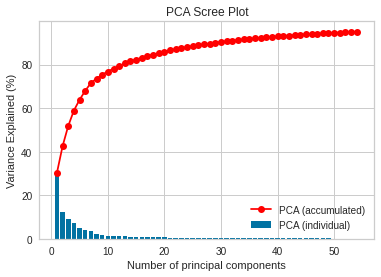

CPU times: user 7.51 s, sys: 3.38 s, total: 10.9 s
Wall time: 1.98 s


In [58]:
%%time
features_pca = hp.reduce_dim(scaler="StandardScaler", data=features_stacked, scree=True)

In [6]:
# np.save('data/vgg16_features_pca.npy', features_pca, allow_pickle=True)
features_pca = np.load('data/vgg16_features_pca.npy', allow_pickle=True)

In [13]:
features_stacked = np.load('data/vgg16_features_stack.npy')
features_stacked.shape

(1050, 4096)

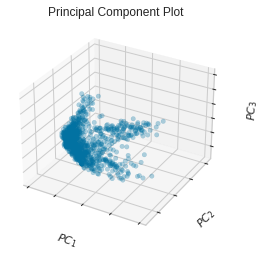

In [21]:
# instantiate PCA from yellowbrick
visualizer_3d_ = yb_PCA(projection=3, alpha=0.3)
# fit and transform word2vec_
visualizer_3d_.fit_transform(features_stacked)
# show visualization
visualizer_3d_.show()
plt.show()

## Classification Non Supervisée - KMeans

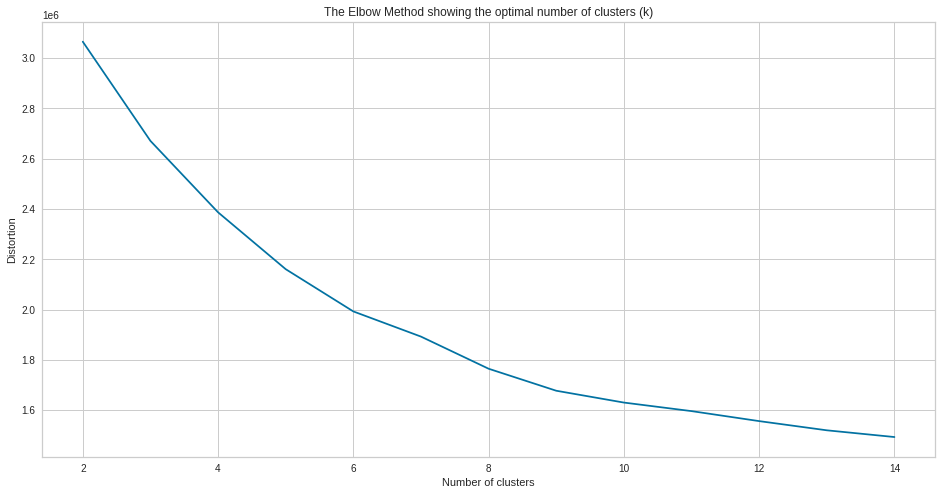

CPU times: user 41.8 s, sys: 31.5 s, total: 1min 13s
Wall time: 11.6 s


In [23]:
%%time
kmeans = hp.find_cluster_numbers(2, 15, features_pca, random_state=1301)

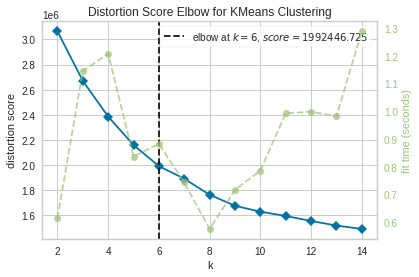

CPU times: user 44.7 s, sys: 30.7 s, total: 1min 15s
Wall time: 12.4 s


In [6]:
%%time
hp.plot_elbow_visualizer(2, 15, features_pca, random_state=1301)

**Remarque**<br>
Le meilleur nombre de clusters est 6.

## Visualisation de Clusters

In [43]:
%%time
# generate TSNE embedded space in 2 dimensions
df_tsne = hp.generate_TSNE_dimensions(features_pca)
# add kmeans cluters in the df
df_tsne["clusters_6"] = kmeans[6]
df_tsne["clusters_7"] = kmeans[7]

CPU times: user 56.3 s, sys: 760 ms, total: 57.1 s
Wall time: 8.21 s


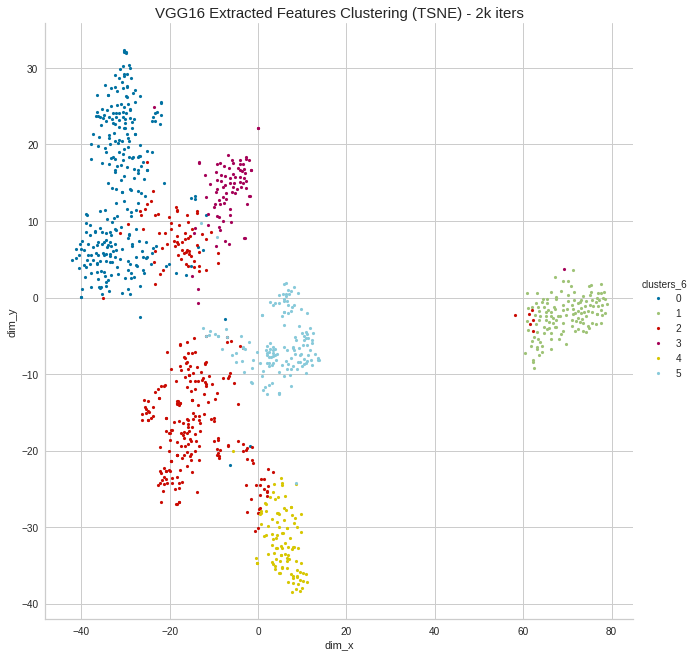

In [38]:
# plot the 6 clusters of the image features extracted by VGG16 model
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne,
    hue="clusters_6",
    title="VGG16 Extracted Features Clustering (TSNE) - 2k iters",
    alpha=1,
)

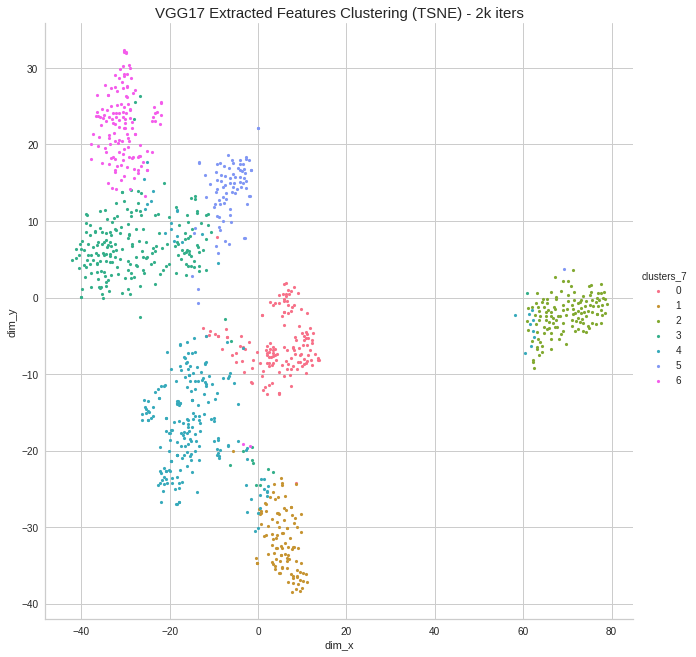

In [37]:
# plot the 7 clusters of the image features extracted by VGG16 model
hp.plot_clusters(
    x="dim_x",
    y="dim_y",
    data=df_tsne,
    hue="clusters_7",
    title="VGG17 Extracted Features Clustering (TSNE) - 2k iters",
    alpha=1,
)

## Comparer le Résultat Clustering de Features Extraites de VGG16 avec les Catégories Produits

In [44]:
# combine clusters assignment with df_cat
df_clusters = df_tsne.copy()
df_clusters['cat'] = df['cat']
df_clusters.sample(5)

,dim_x,dim_y,clusters_6,clusters_7,cat
129,-1.861216,-9.341928,0,0,Kitchen & Dining
697,-17.563673,-9.499265,4,4,Home Decor & Festive Needs
471,9.944284,-5.440364,0,0,Kitchen & Dining
308,-5.486571,-20.194836,1,1,Home Decor & Festive Needs
797,-32.978695,7.752454,3,3,Beauty and Personal Care


### 6 Clusters

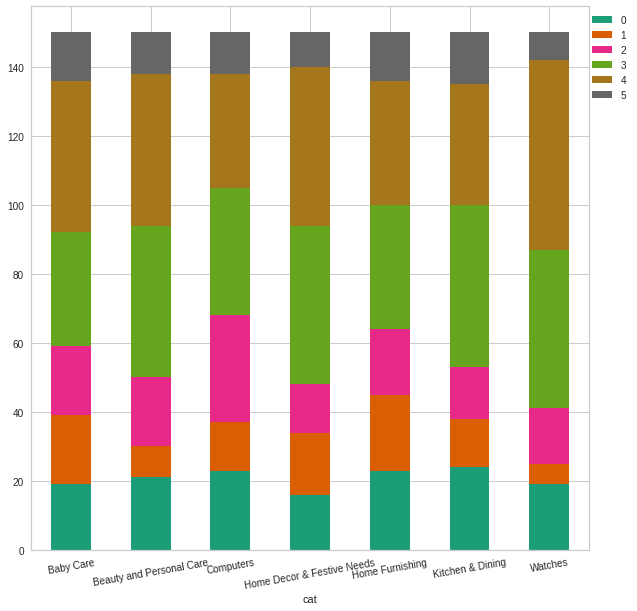

In [47]:
# group clusters_6 by cat
hp.plot_stacked_barchart(df_clusters, "cat", "clusters_6")

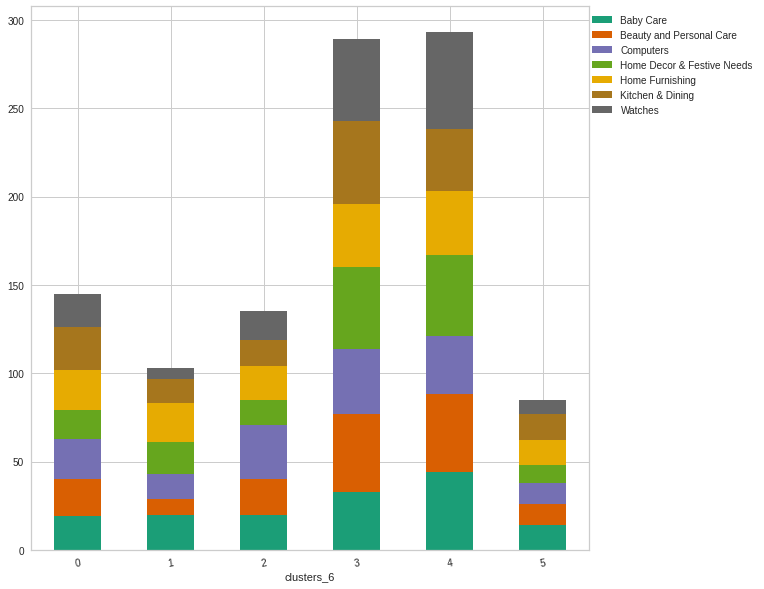

In [46]:
# group cat by clusters_6
hp.plot_stacked_barchart(df_clusters, "clusters_6", "cat")

### 7 Clusters

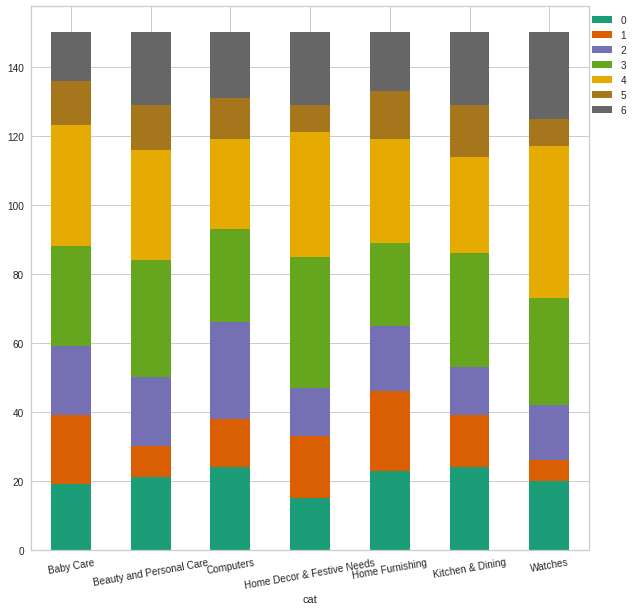

In [13]:
# group clusters_7 by cat
hp.plot_stacked_barchart(df_clusters, "cat", "clusters_7")

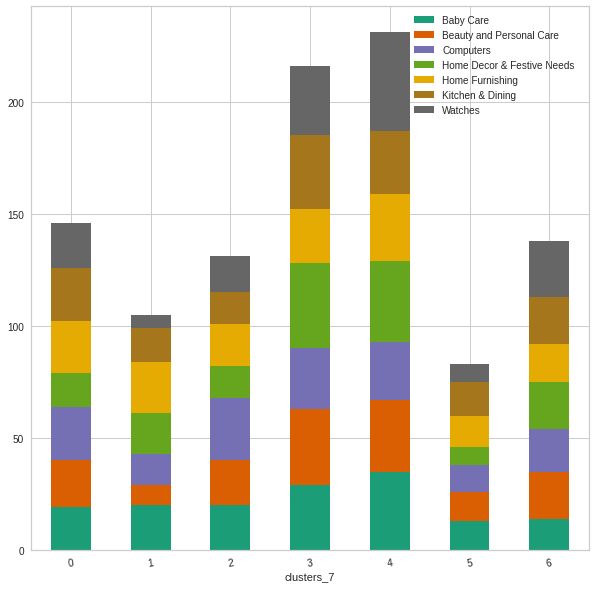

In [14]:
# group cat by clusters_7
hp.plot_stacked_barchart(df_clusters, "clusters_7", "cat")

# END